<a href="https://colab.research.google.com/github/quangvan99/guide/blob/khoa/PyTorch_Neutral_Network/PyTorch_Neutral_NetWork_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neutral Network
1. Neuron: Dữ liệu đầu vào đi qua một hàm tuyến tính, sau đó đi qua một hàm phi tuyến (kích hoạt) để tạo đầu ra
2. Layer:
- Gồm tập hợp nhiều các Neuron được nối với các trọng số (weights) khác nhau, các neuron trong cùng 1 layer không kết nối với nhau
- Cấu trúc neutral network gồm 3 loại layer với vô hạn số lượng layer Input - Hidden - Output

**Tóm lại, neutral network cơ bản là một tập hợp các phép tuyến tính cơ bản(neuron) được kết nối với các trọng số (weight)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import numpy as np

import requests
from pathlib import Path

In [ ]:
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,noise=0.03, #nhiễu
                    random_state=42) # = seed

In [ ]:
print(f'First 5 rows of X: {X[:5]}') # đàu vào
print()
print(f'First 5 rows of y: {y[:5]}') # nhãn để phân loại hoặc thể hiện các layer

First 5 rows of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 rows of y: [1 1 1 1 0]


In [ ]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
circles.label.value_counts()

,count
label,
1,500
0,500


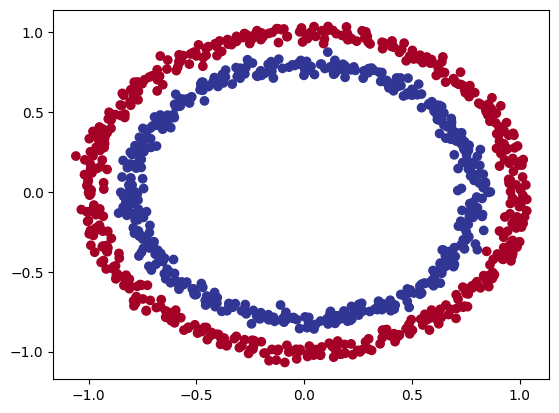

In [ ]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
torch.__version__

'2.5.1+cu121'

In [ ]:
print(type(X))
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


X[:5],y[:5]

<class 'numpy.ndarray'>


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test,80% train
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Xây dựng Model

1. Cài đặt thiết bị (để model có thể chạy trên cả CPU và GPU)
2. Xây dựng model bằng cách kế thừa lớp `nn.Module`
3. Định nghĩa hàm mất mát và tối ưu
4. Tạo vòng Training Loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5) # 2 gtri vào và 5 gtri ra
    self.layer_2 = nn.Linear(in_features=5,out_features=1) # 5 vào và 1 ra


  def forward(self,x):
    x = torch.relu(self.layer_1(x)) # Hàm kích hoạt để học phi tuyến
    return self.layer_2(x) # Nếu cho sigmoid vào thì phải dùng BCE ở bên dưới thay vì BCEwithlogitsloss

    # return torch.sigmoid(self.layer_2(x))
    # return self.layer_2(self.layer_1)

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#X_test = torch.from_numpy(X_test).type(torch.float).to(device)
#y_test = torch.from_numpy(y_test).type(torch.float).to(device)


untrained_preds = model_0(X_test.to(device))
print(f"Độ dài của dự đoán: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Độ dài của ví dụ test: {len(y_test)}, Shape: {y_test.shape}")
print(f"\n10 giá trị dự đoán:\n{untrained_preds[:10]}")
print(f"\n10 test label:\n{y_test[:10]}")

Độ dài của dự đoán: 200, Shape: torch.Size([200, 1])
Độ dài của ví dụ test: 200, Shape: torch.Size([200])

10 giá trị dự đoán:
tensor([[-0.6506],
        [-0.6700],
        [-0.6144],
        [-0.6930],
        [-0.5078],
        [-0.4466],
        [-0.5379],
        [-0.4651],
        [-0.6186],
        [-0.6696]], grad_fn=<SliceBackward0>)

10 test label:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
#Tạo hàm mất mát Binary Cross Entropy
loss_fn = nn.BCEWithLogitsLoss()

#Tạo hàm tối ưu
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred): # Hàm tính độ chính xác
  correct = torch.eq(y_true, y_pred).sum().item() # lần lượt so sánh 2 giá trị với nhau, sum() đếm số lần True, item() trả về kiểu int
  acc = (correct / len(y_pred)) * 100
  return acc

# 3.Train Model


In [ ]:
y_logits = model_0(X_test.to(device))[:5]

# model_0 = model_0.to(device)
# print(f"Model 0 on device: {next(model_0.parameters()).device}")
print(y_logits)

tensor([[-0.6506],
        [-0.6700],
        [-0.6144],
        [-0.6930],
        [-0.5078]], grad_fn=<SliceBackward0>)


In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3428],
        [0.3385],
        [0.3511],
        [0.3334],
        [0.3757]], grad_fn=<SigmoidBackward0>)

# Important Commands

1. `to(device)` : Chuyển dữ liệu về device cùng nhau
2. `model_0(X_test.to(device))` : Tính đầu ra thô X_test
3. `torch.sigmoid` : Chuyển thành xác xuất [0,1]
4. `round()` : Làm tròn về 0 hoặc 1

In [ ]:
# Tìm dự đoán, làm tròn về 0 hoặc 1
y_preds = torch.round(y_pred_probs)

# Tính toán đầu ra và làm tròn nhãn
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# So sánh kiểm tra tương đồng giữa 2 kq
print(torch.eq(y_preds.squeeze(), # squeeze() : Loại bỏ chiều dư thừa nếu có
               y_pred_labels.squeeze()))

# Loại bỏ chiều dư thừa
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
torch.manual_seed(42)

test = 100



# X_train = torch.from_numpy(X_train).type(torch.float).to(device)
# X_test = torch.from_numpy(X_test).type(torch.float).to(device)
# y_train = torch.from_numpy(y_train).type(torch.float).to(device)
# y_test = torch.from_numpy(y_test).type(torch.float).to(device)

# Đẩy data với thiết bị nhắm tới
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Xây dựng vòng lặp training và dự đoán
for test in range(test):
  model_0.train()

  # 1.Forward pass (raw logits)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2.Tính toán hàm loss, độ chính xác
  # loss = loss_fn(torch.sigmoid(y_logits), y_train)      # BCELoss cần có thêm sigmoid
  loss = loss_fn(y_logits, y_train)                       # BCEWithLogitsLoss có thể làm việc với raw data
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3.Tối ưu zero grad, gradient = 0 mỗi lần lặp
  optimizer.zero_grad()

  # 4.Tính đạo hàm
  loss.backward()

  # 5.Tối ưu
  optimizer.step()


  model_0.eval() # Chuyển sang chế độ đánh giá
  with torch.inference_mode(): # Tắt tính toán gradient
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2.Caculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)


    if test % 10 == 0:
      print(f"Test: {test} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Test: 0 | Loss: 0.73107, Acc: 50.00% | Test Loss: 0.72971, Test Acc: 50.00%
Test: 10 | Loss: 0.70652, Acc: 50.00% | Test Loss: 0.70657, Test Acc: 50.00%
Test: 20 | Loss: 0.69620, Acc: 50.00% | Test Loss: 0.69674, Test Acc: 50.00%
Test: 30 | Loss: 0.69177, Acc: 50.00% | Test Loss: 0.69248, Test Acc: 50.00%
Test: 40 | Loss: 0.68978, Acc: 50.00% | Test Loss: 0.69057, Test Acc: 50.00%
Test: 50 | Loss: 0.68881, Acc: 48.62% | Test Loss: 0.68966, Test Acc: 49.50%
Test: 60 | Loss: 0.68825, Acc: 50.12% | Test Loss: 0.68918, Test Acc: 51.50%
Test: 70 | Loss: 0.68785, Acc: 52.12% | Test Loss: 0.68888, Test Acc: 52.50%
Test: 80 | Loss: 0.68753, Acc: 52.12% | Test Loss: 0.68867, Test Acc: 53.00%
Test: 90 | Loss: 0.68722, Acc: 53.37% | Test Loss: 0.68849, Test Acc: 53.00%


In [ ]:
import requests
from pathlib import Path

# Tải các hàm hỗ trợ về
if Path("helper_functions.py").is_file():
  print("Đã có helper_functions.py")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

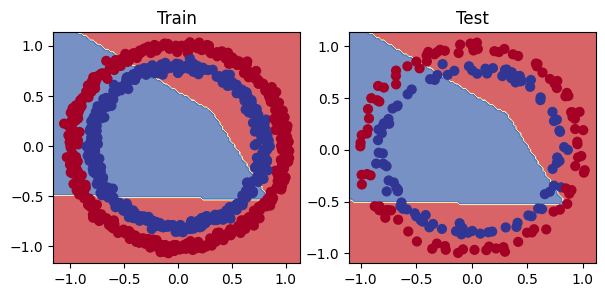

In [ ]:
# Vẽ đường quyết định (decision boundaries) cho tập huấn luyện và test
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
print(model_1)
print(f"Model 1 on device: {next(model_1.parameters()).device}")
model_1 = model_1.to(device)
print(f"Model 1 on device: {next(model_1.parameters()).device}")

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)
Model 1 on device: cpu
Model 1 on device: cpu


In [ ]:
# loss_fn = nn.BCELoss() cần sigmoid
loss_fn = nn.BCEWithLogitsLoss() # không cần
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

test = 1000


# X_train = torch.from_numpy(X_train).type(torch.float).to(device)
# X_test = torch.from_numpy(X_test).type(torch.float).to(device)
# y_train = torch.from_numpy(y_train).type(torch.float).to(device)
# y_test = torch.from_numpy(y_test).type(torch.float).to(device)


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for test in range(test):
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()                    # Dự đoán đầu ra, loại bỏ chiều dư thừa
    y_pred = torch.round(torch.sigmoid(y_logits))            # Làm tròn

    # 2. Tính toán độ chính xác
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. zero grad
    optimizer.zero_grad()

    # 4. tính đạo hàm của hàm loss
    loss.backward()

    # 5. Cập nhật tham số
    optimizer.step()


    model_1.eval()
    with torch.inference_mode(): #tắt tính toán gradient
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Tính toán độ chính xác
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if test % 100 == 0:
        print(f"Test: {test} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Test: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Test: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Test: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Test: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Test: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Test: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Test: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Test: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Test: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Test: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


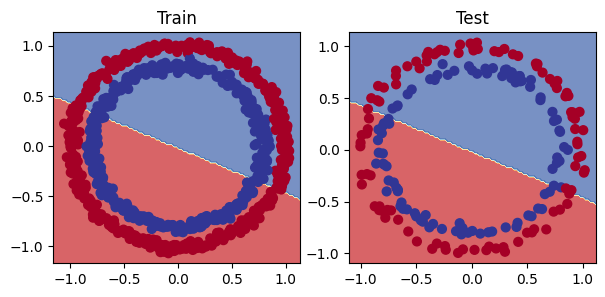

In [ ]:
# Vẽ đường quyết định (decision boundaries) cho tập huấn luyện và test
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Tạo data
X_reg = torch.arange(start, end, step).unsqueeze(dim=1)
y_reg = weight * X_reg + bias


print(len(X_reg))
X_reg[:5], y_reg[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
split = int(0.8 * len(X_reg)) # 80% train 20% test
X_train_reg, y_train_reg = X_reg[:split], y_reg[:split]
X_test_reg, y_test_reg = X_reg[split:], y_reg[split:]


print(len(X_train_reg),
    len(y_train_reg),
    len(X_test_reg),
    len(y_test_reg))

80 80 20 20


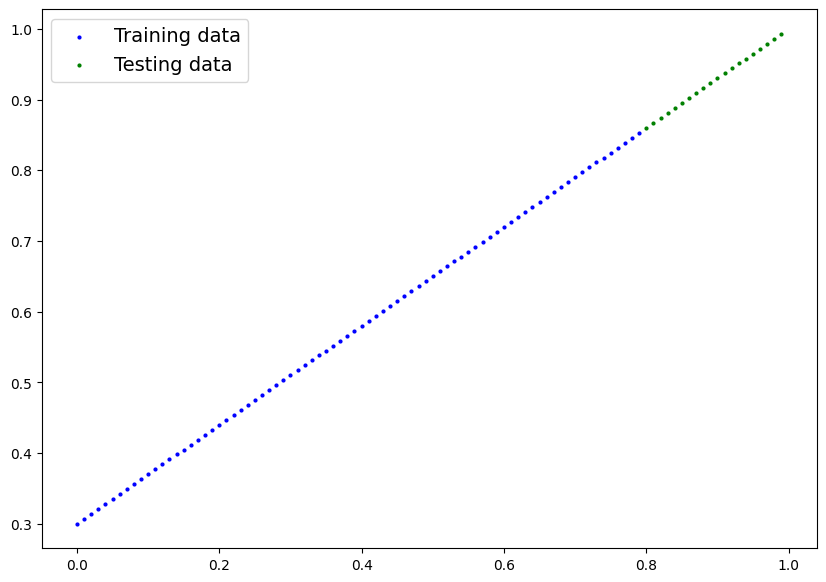

In [ ]:
plot_predictions(train_data=X_train_reg,
                 train_labels = y_train_reg,
                 test_data = X_test_reg,
                 test_labels = y_test_reg);

# nn.Sequential cho phép sắp xếp các layer trong 1 model theo thứ tự, giữa các layer có thể chèn trực tiếp hàm kích hoạt vì vậy nó không cần hàm forward như các model trên

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    # nn.ReLU(),
    nn.Linear(in_features=10,out_features=10),
    # nn.ReLU(),
    nn.Linear(in_features=10,out_features=1)
).to(device)
# Không dùng ReLU ở đây do gặp vanishing gradient(vì bị đẩy quá nhiều về 0), model quá đơn giản thì không cần hàm kích hoạt vì nó không cần học phi tuyến
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),lr=0.001)

In [ ]:
torch.manual_seed(42)

test = 1000

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for test in range(test):
    y_pred = model_2(X_train_reg)

    loss = loss_fn(y_pred, y_train_reg)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
      test_pred = model_2(X_test_reg)
      test_loss = loss_fn(test_pred,y_test_reg)

    if test % 100 == 0:
      print(f"Test: {test} | Train Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Test: 0 | Train Loss: 0.75986 | Test loss: 0.94965
Test: 100 | Train Loss: 0.40272 | Test loss: 0.54029
Test: 200 | Train Loss: 0.05876 | Test loss: 0.13480
Test: 300 | Train Loss: 0.01461 | Test loss: 0.03342
Test: 400 | Train Loss: 0.00308 | Test loss: 0.00008
Test: 500 | Train Loss: 0.00309 | Test loss: 0.00012
Test: 600 | Train Loss: 0.00309 | Test loss: 0.00018
Test: 700 | Train Loss: 0.00299 | Test loss: 0.00011
Test: 800 | Train Loss: 0.00299 | Test loss: 0.00016
Test: 900 | Train Loss: 0.00289 | Test loss: 0.00011


Matplotlib không thể xử lí data ở GPU, nên phải dùng `.cpu()` để chuyển về

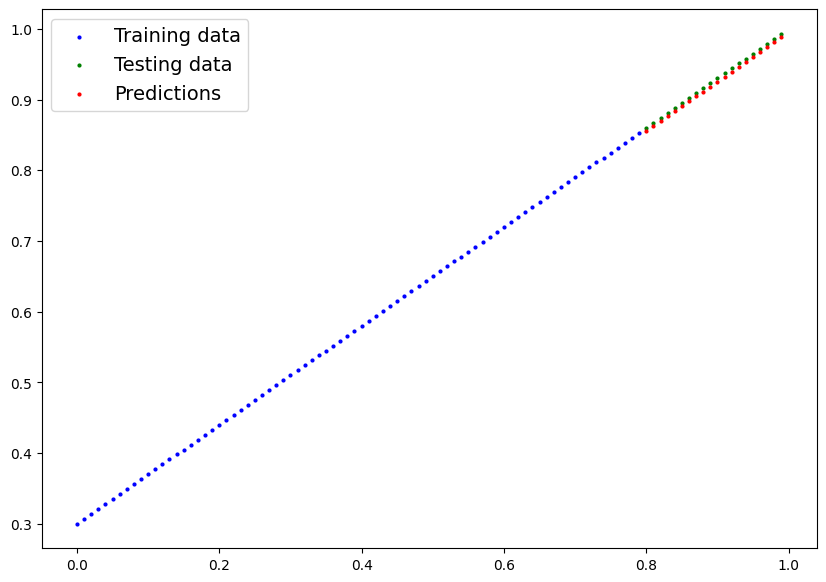

In [ ]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_reg)


plot_predictions(train_data=X_train_reg.cpu(),
          train_labels=y_train_reg.cpu(),
          test_data=X_test_reg.cpu(),
          test_labels=y_test_reg.cpu(),
          predictions=y_preds.cpu());

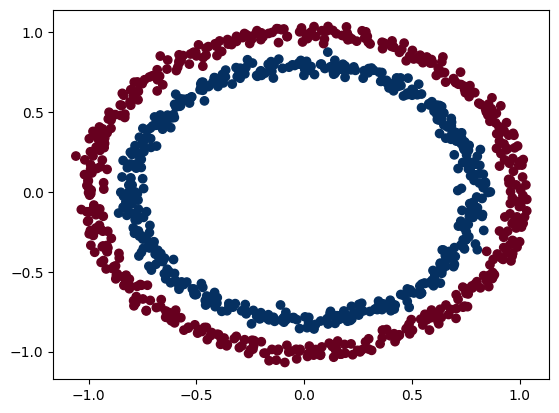

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
# Tạo model với hàm kích hoạt (activation function) phi tuyến (non-linear)
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()



    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

test = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for test in range(test):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) #logits -> prediction

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if test % 100 == 0:
        print(f"Test: {test} | Train Loss: {loss:.5f}, Độ chính xác: {acc:.2f}% | Test loss: {test_loss:.5f}, Độ chính xác: {test_acc:.2f}")

Test: 0 | Train Loss: 0.07083, Độ chính xác: 99.88% | Test loss: 0.10316, Độ chính xác: 99.50
Test: 100 | Train Loss: 0.06926, Độ chính xác: 99.88% | Test loss: 0.10124, Độ chính xác: 99.50
Test: 200 | Train Loss: 0.06776, Độ chính xác: 99.88% | Test loss: 0.09937, Độ chính xác: 99.50
Test: 300 | Train Loss: 0.06631, Độ chính xác: 99.88% | Test loss: 0.09759, Độ chính xác: 99.50
Test: 400 | Train Loss: 0.06492, Độ chính xác: 99.88% | Test loss: 0.09592, Độ chính xác: 99.50
Test: 500 | Train Loss: 0.06358, Độ chính xác: 99.88% | Test loss: 0.09427, Độ chính xác: 99.50
Test: 600 | Train Loss: 0.06230, Độ chính xác: 99.88% | Test loss: 0.09266, Độ chính xác: 99.50
Test: 700 | Train Loss: 0.06106, Độ chính xác: 99.88% | Test loss: 0.09110, Độ chính xác: 99.50
Test: 800 | Train Loss: 0.05987, Độ chính xác: 99.88% | Test loss: 0.08959, Độ chính xác: 99.50
Test: 900 | Train Loss: 0.05873, Độ chính xác: 99.88% | Test loss: 0.08812, Độ chính xác: 99.50


In [ ]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

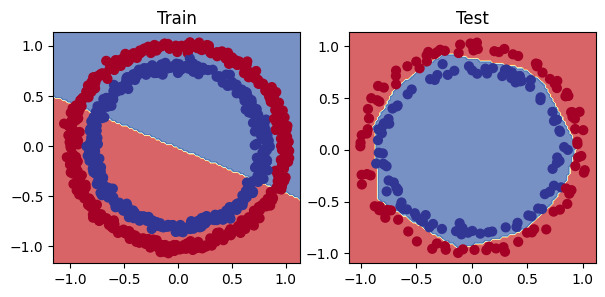

In [ ]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 không có phi tuyến
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 có tính phi tuyến

In [ ]:
from pathlib import Path

# 1. Tạo nơi ở cho model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Save path
MODEL_NAME = "pytorch_neutral_network-model_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_neutral_network-model_3.pth


In [ ]:
loaded_model_3 = CircleModelV2()
loaded_model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_3.to(device)